In [2]:
from glob import glob
import torch
from torch.utils.data import DataLoader
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from torchvision.transforms import v2 as T
import albumentations as A
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from torchmetrics import JaccardIndex
from albumentations.pytorch import ToTensorV2

ModuleNotFoundError: No module named 'torch'

In [4]:
torch.cuda.is_available()

NameError: name 'torch' is not defined

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Создание Dataset

In [ ]:
def get_numbers_livers(paths_masks:list) -> set:
        numbers = []
        for path_i in sorted(glob(paths_masks)):
            index_split = path_i.rfind('-') + 1
            num = path_i[index_split:-4]
            if num in numbers:
                raise 'there is already such a number'
            numbers.append(num)
        return numbers
    
    
def convert_number_to_path(number, flag:bool, part='') -> str:
    mask_feature = f'/kaggle/input/liver-tumor-segmentation/volume_pt{part}/volume-'
    mask_target = '/kaggle/input/liver-tumor-segmentation/segmentations/segmentation-'
    
    if flag:
        return mask_feature + str(number) + '.nii'
    return mask_target + str(number) + '.nii'


def get_paths_df(paths_features_masks, paths_targets_masks) -> tuple:
    paths_features = []
    paths_targets = []
    numbers_targets = get_numbers_livers(paths_targets_masks)
    for index, path in enumerate(paths_features_masks):
        for num in get_numbers_livers(path):
            if num in numbers_targets:
                paths_features.append(convert_number_to_path(num, True, index + 1))
                paths_targets.append(convert_number_to_path(num, False))
    return np.array(paths_features), np.array(paths_targets)



class LiverDataset:
    def __init__(self, transformation, cnt_read_images3d=5, train=True):
        paths_features_masks = [f'/kaggle/input/liver-tumor-segmentation/volume_pt{i}/*.nii' for i in range(1, 5 + 1)]
        paths_targets_masks = '/kaggle/input/liver-tumor-segmentation/segmentations/*.nii'
        self.train = train
        self.transformation = transformation
        
        self.trans_standart = A.Compose([
            A.Resize(height=256, width=256),
            ToTensorV2(),
        ])
        
        paths_features, paths_targets = get_paths_df(paths_features_masks, paths_targets_masks)
        
        
        size = int(len(paths_features) * 0.1)
        mask = np.arange(len(paths_features))
        np.random.seed(0)
        indexs = np.random.choice(mask, size=size, replace=False)
        mask[indexs] = 0
        mask[mask != 0] = 1 
        mask = mask.astype(bool)
        
        if train:
            paths_features = paths_features[mask]
            paths_targets = paths_targets[mask]
        else:
            paths_features = paths_features[~mask]
            paths_targets = paths_targets[~mask]
        
        self.features, self.targets = self.load_data(paths_features, paths_targets, cnt_read_images3d)
  
    
    def __getitem__(self, index):
        img_feature, img_target = self.features[index], self.targets[index]
        trans = self.transformation(image=img_feature, mask=img_target)
        mask = trans['mask'].unsqueeze(0)
        return trans['image'], mask
    
    def __len__(self):
        return len(self.features)
    
    def load_data(self, paths_features, paths_targets, cnt_3d_imgs=10) -> tuple:
        cnt = 0
        features = []
        targets = []
        
        for i, (path_feature, path_target) in enumerate(zip(paths_features, paths_targets)):
            if cnt == cnt_3d_imgs:
                break
            print(cnt)
            cnt += 1


            img_3d_feature = nib.load(path_feature).get_fdata().transpose(2,0,1)
            img_3d_target = nib.load(path_target).get_fdata().transpose(2,0,1)


            for img_feature, img_target in zip(img_3d_feature, img_3d_target):
                if len(np.unique(img_target)) != 3:
                    continue
                if len(img_target[img_target==2]) <= 250:
                    continue

                img_feature = (img_feature - mean) / std
                trans = self.trans_standart(image=img_feature, mask=img_target)
                img_feature_ = trans['image'].squeeze(0).float()
                img_target_ = trans['mask'].long()

                features.append(img_feature_)
                targets.append(img_target_)

        return np.array(features), np.array(targets)

In [ ]:
"""
root = "/kaggle/input/3d-liver-segmentation"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 128, 128
trans = A.Compose( [A.Resize(im_h, im_w), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls, ds = get_dls(root = root, transformations = trans, bs = 16)
"""

# Аугментация

In [ ]:
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.Resize(height=256, width=256),
    ToTensorV2(),
])

transform_val = A.Compose([
    A.Resize(height=256, width=256),
    ToTensorV2(),
])

In [ ]:
cnt = 10000000000
df_train = LiverDataset(transform_train, cnt)
df_test = LiverDataset(transform_val, cnt, train=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


42


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


43


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


44
0
1
2
3
4
5


1878
289

# DataLoader

In [ ]:
batch_size = 8
tr_loader = DataLoader(df_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(df_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)

In [ ]:
print(tr_loader)
print(val_loader)

# Предподготовка данных стандартизацию

In [ ]:
mean = np.empty(len(df_train))
std = np.empty(len(df_train))
for i, (x, y) in enumerate(df_train):
    mean[i] = x.mean()
    std[i] = x.std()
mean = mean.mean()
std = std.mean()

In [ ]:
mean, std

In [ ]:
"""
тут тестим нормализацию nii
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)
    """

# UNET

In [ ]:
def conv_plus_conv(in_channels: int, out_channels: int):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )


class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 32

        self.down1 = conv_plus_conv(1, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8)

        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels * 4, base_channels)
        self.up3 = conv_plus_conv(base_channels * 8, base_channels * 2)
        self.up4 = conv_plus_conv(base_channels * 16, base_channels * 4)

        self.bottleneck = conv_plus_conv(base_channels * 8, base_channels * 8)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        
        residual1 = self.down1(x)  
        x = self.downsample(residual1) 

        residual2 = self.down2(x)  
        x = self.downsample(residual2)
        
        residual3 = self.down3(x)
        x = self.downsample(residual3)
        
        residual4 = self.down4(x)
        x = self.downsample(residual4) 
        
        x = self.bottleneck(x) 
        
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual4), dim=1)
        x = self.up4(x)
        
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual3), dim=1)
        x = self.up3(x)
        
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual2), dim=1)
        x = self.up2(x)

        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual1), dim=1)  
        x = self.up1(x)  

        return self.out(x)

In [ ]:
def create_fcn_model(input_shape=(256, 256, 1), target_shape=(256, 256, 3)):
    model = keras.Sequential()

    # кодируем лэерпулы 
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    # декод, повышаем качество
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(3, (1, 1), activation='softmax')) # выходной слой 

    crop_height = (model.output_shape[1] - target_shape[0]) // 2
    crop_width = (model.output_shape[2] - target_shape[1]) // 2
    model.add(layers.Cropping2D(cropping=((crop_height, crop_height), (crop_width, crop_width))))

    return model

In [ ]:
def train(model, tr_loader):
    model.train()

    train_loss = 0
    jaccard_cnt = 0

    for x, y in tqdm(tr_loader, desc='Train'):
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred.reshape(8, 3, -1), y.reshape(8, -1).long())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = model(x).squeeze(0).max(dim=1)[1].cpu()
        jaccard_cnt += jaccard(pred, y.squeeze(1).cpu()).item()
    
    if scheduler._step_count < 25:
        scheduler.step()

    train_loss /= len(tr_loader)
    jaccard_cnt /= len(tr_loader)
    return (train_loss, jaccard_cnt)

In [ ]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    val_loss = 0
    jaccard_cnt = 0

    for x, y in tqdm(loader, desc='Test'):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        loss = loss_fn(pred.reshape(8, 3, -1), y.reshape(8, -1).long())
        val_loss += loss.item()
        pred = model(x).squeeze(0).max(dim=1)[1].cpu()
        jaccard_cnt += jaccard(pred, y.squeeze(1).cpu()).item()

    val_loss /= len(loader)
    
    jaccard_cnt /= len(loader)
    return (val_loss, jaccard_cnt)

In [ ]:
def plot_stats(train_loss, valid_loss, train_jaccard, val_jaccard):
    
    plt.figure(figsize=(16, 8))
    plt.title('loss')
    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.ylim(0,0.25)
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(16, 8))
    plt.title('jaccard')
    plt.plot(train_jaccard, label='Train jaccard')
    plt.plot(val_jaccard, label='Valid jaccard')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def epoh_train(model, tr_loader, valid_loader, num_epochs):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, tr_loader)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()
        
        print('lr:', scheduler.get_last_lr()[0])
        print('tr_loss:', train_loss)
        print('val_loss:', valid_loss)
        
        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
        )

In [ ]:
unet_model = UNET()
unet_model = unet_model.to(device)

In [ ]:
torch.save(unet_model, 'unet_tumor_08')

In [ ]:
unet_model = torch.load('/kaggle/input/model-unet-w/unet_tumor_08')

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-4, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20) # Rprop(params, lr=1e-4, etas=(0.5, 1.2), betas=(0.9, 0.999), step_sizes=(1e-06, 50))

lr: 0.0001
tr_loss: 0.013617249700978312
val_loss: 0.025231845987339813


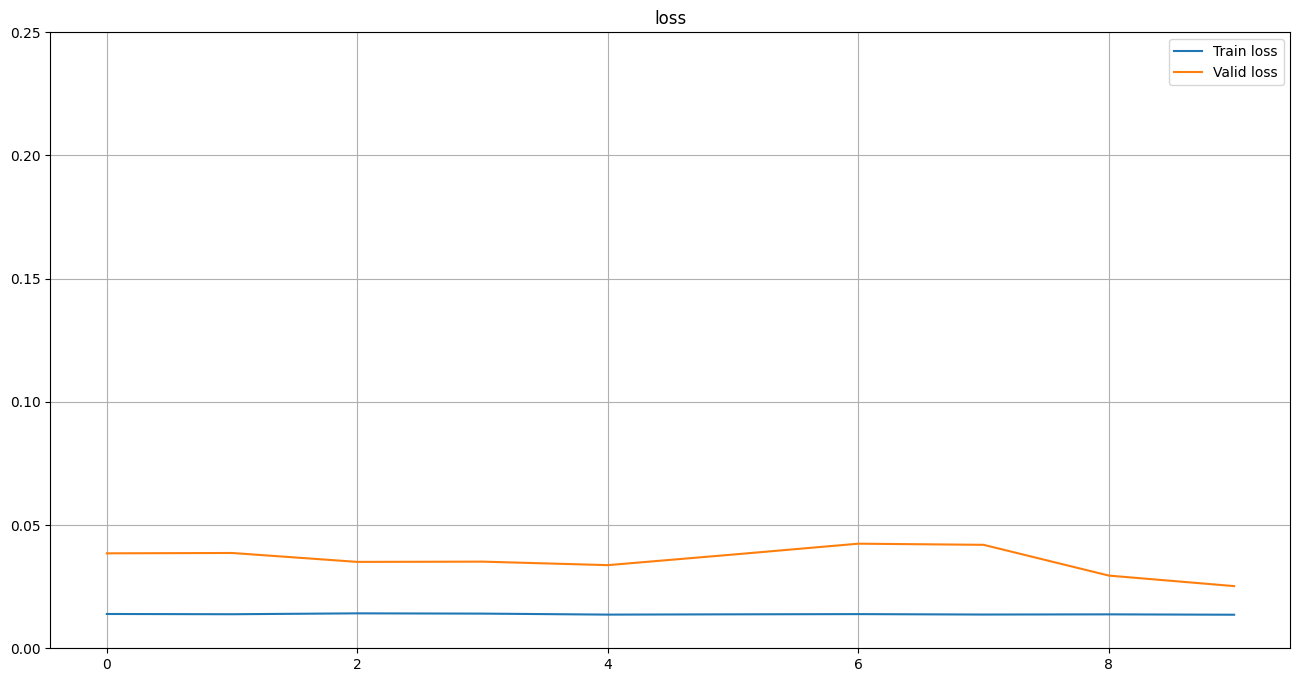

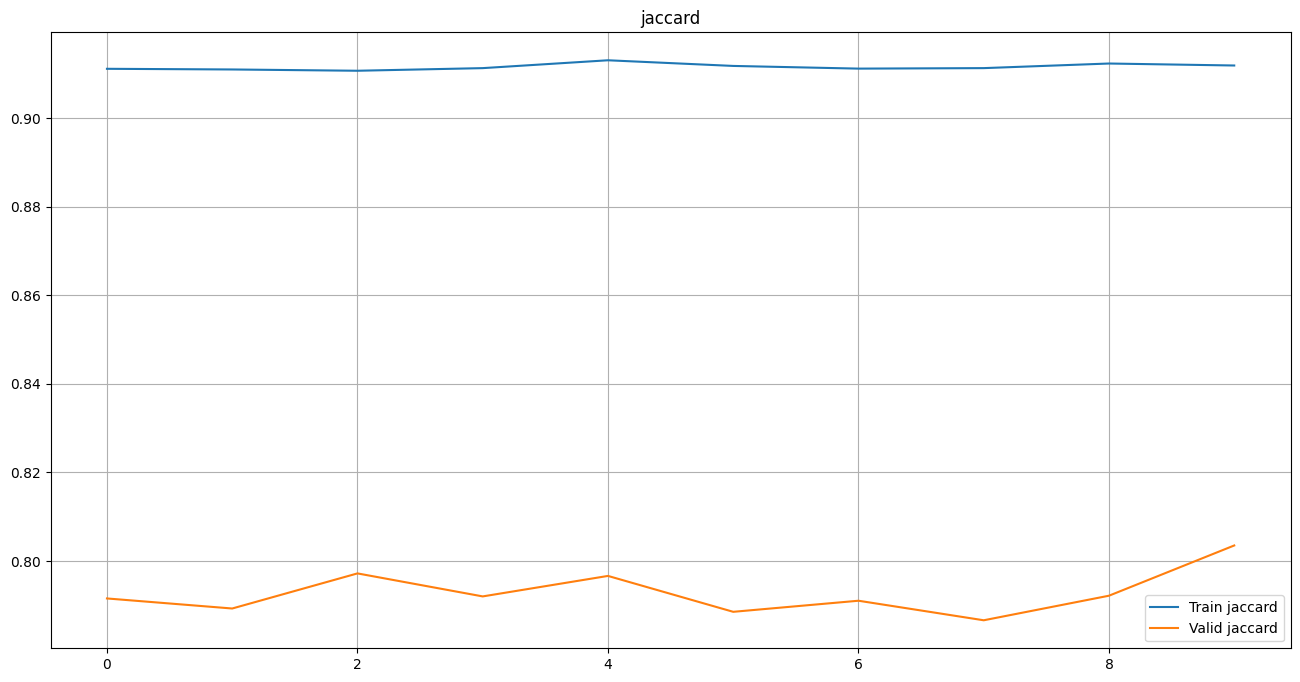

Train:  10%|█         | 18/173 [00:03<00:30,  5.02it/s]


KeyboardInterrupt: 

In [ ]:
epoh_train(unet_model, tr_loader, val_loader, 50) # 15 30 45 

/tmp/ipykernel_34/2839733912.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).float().squeeze(0)
/tmp/ipykernel_34/2839733912.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).long()


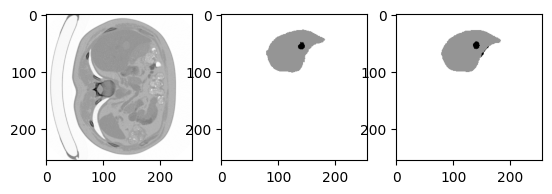

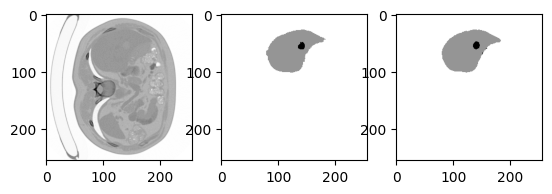

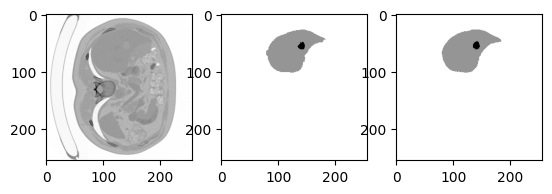

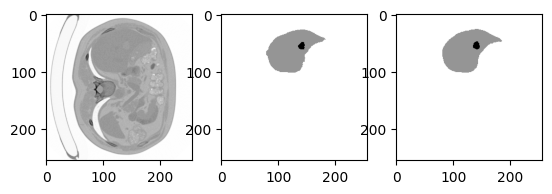

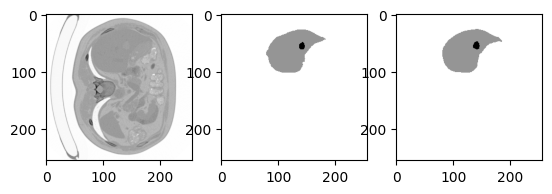

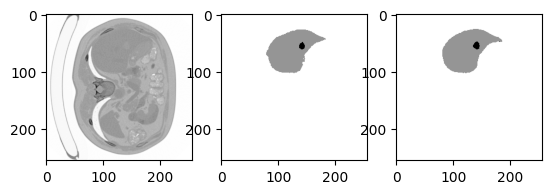

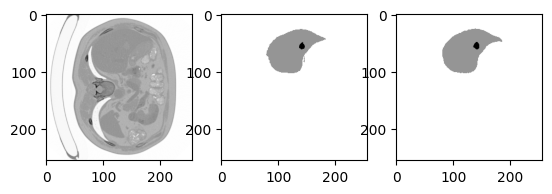

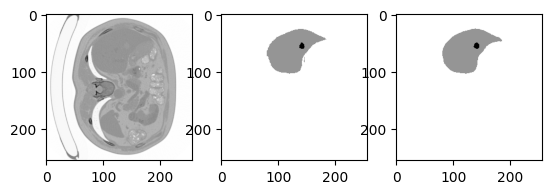

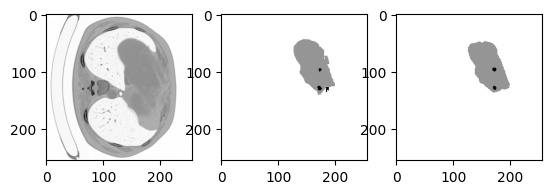

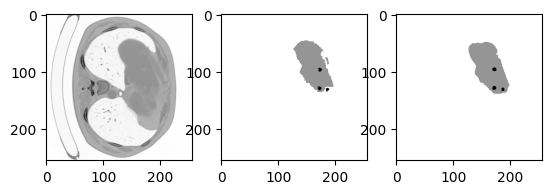

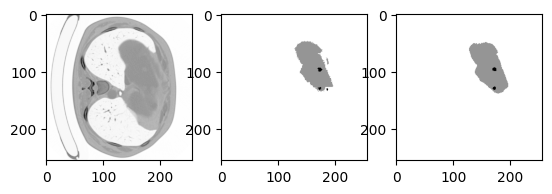

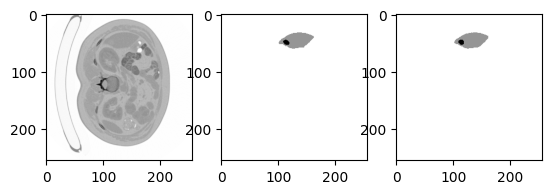

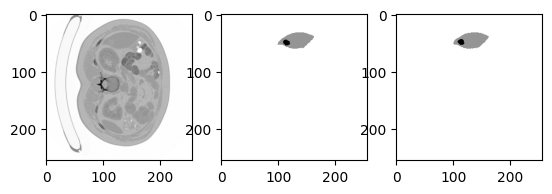

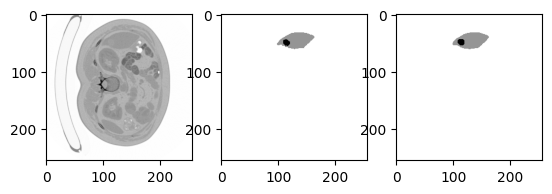

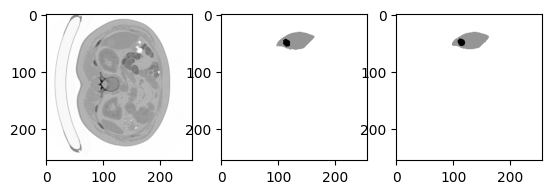

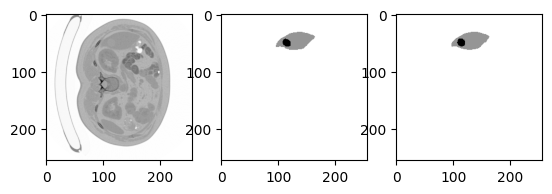

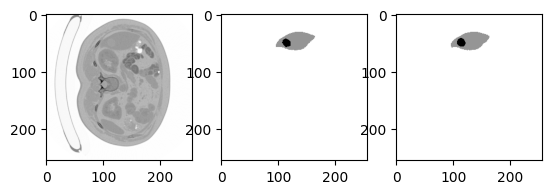

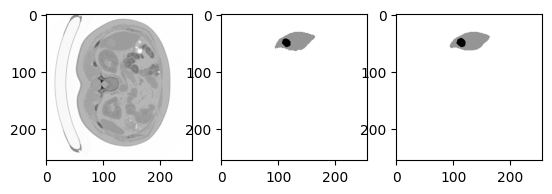

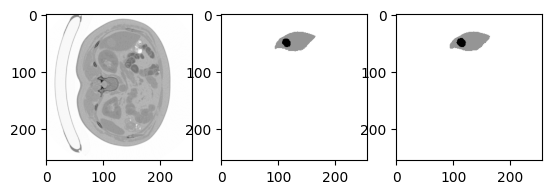

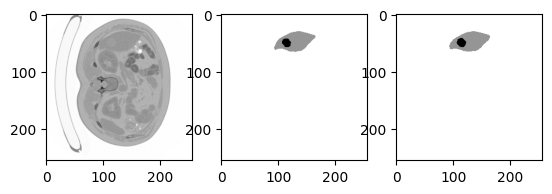

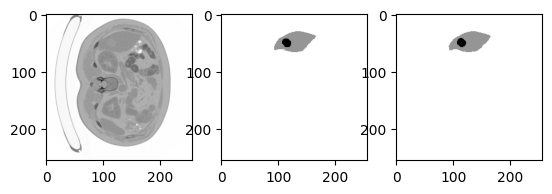

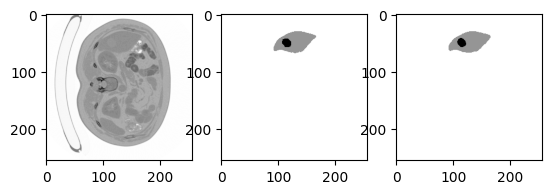

KeyboardInterrupt: 

In [ ]:
unet_model.eval()
cnt = 0
jaccard = JaccardIndex(task='multiclass', num_classes=3)
jaccard_cnt = 0
for x, y in df_test:
    cnt += 1
    if cnt < 30:
        continue
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(x.squeeze(0), cmap='Greys')
    ax[1].imshow(y.squeeze(0), cmap='Greys')
    
    x = torch.tensor(x).float().squeeze(0)
    y = torch.tensor(y).long()
    
    with torch.no_grad():
        pred = unet_model(x.unsqueeze(0).unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1].cpu()
    
    jaccard_cnt += jaccard(pred, y.squeeze(0)).item()

    ax[2].imshow(pred, cmap='Greys')
    plt.show()
print(jaccard_cnt / cnt)

In [3]:
mean = -644.2137072615333 # -635.45732381634
std = 673.311976351113 # 691.4678393952738
jaccard = JaccardIndex(task='multiclass', num_classes=3)

NameError: name 'JaccardIndex' is not defined